In [1]:
import math
import numpy as np
import pylab as plt
plt.style.use('./matplotlib.style')
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
import scipy.io
from tqdm import tqdm
from utils import getR
import sys
sys.path.append('./pytorch_nufft')
from pytorch_nufft import nufft

gyromagnetic_ratio = 42.58 # MHz / T ~ kHz / mT

from typing import List, Tuple
def gtime(seq: List[Tuple]):
    res = []
    t = 0
    for (dt, n) in seq:
        res.append(np.linspace(t, t + dt * n, n))
        t = t + dt * n
    return np.concatenate(res)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([256, 256, 3])


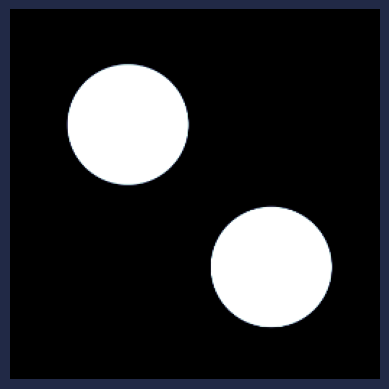

In [2]:
import cv2
import io
figures = [
    [
        plt.Circle((0.5, 0.5), 0.5, color='w'),
        plt.Circle((0.5, 0.5), 0.3, color='k')
    ],
    [
        plt.Circle((0.75, 0.25), 0.21, color='w'),
        plt.Circle((0.25, 0.75), 0.21, color='w'),
    ],
]

fig, ax = plt.subplots()
for patch in figures[1]:
    ax.add_patch(patch)
plt.axis('off')
io_buf = io.BytesIO()
fig.savefig(io_buf, format='raw')
io_buf.seek(0)
img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
img = torch.from_numpy(cv2.resize(img_arr[:,:,0], (256,256))).float()
io_buf.close()
plt.close()

img = img[:, :, None].repeat(1,1,3)
print(img.shape)
plt.imshow(img[:,:,0], cmap=plt.cm.bone)
plt.axis(False)
plt.show()

In [3]:
img = torch.from_numpy(skimage.data.astronaut() * 1.0)[::2, ::2].float()
img *= 1. / img.max()
print(img.shape)
rho_map = img[:,:,0]
t1_map = img[:,:,1] * 3000 + 1000
t2_map = img[:,:,2] * 1000 + 1000

torch.Size([256, 256, 3])


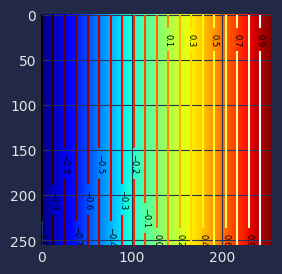

In [4]:
x = torch.linspace(-1.0, 1.0, 256) # x [m]
y = torch.linspace(-1.0, 1.0, 256) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')

theta = torch.arange(0, 3).deg2rad()[None, None, :]
B1 = X[:, :, None] * torch.sin(theta) + Y[:, :, None] * torch.cos(theta)
B1.shape
plt.figure(figsize=(3,3))
plt.imshow(B1[:, :, 0], cmap=plt.cm.jet)
cs = plt.contour(B1[:, :, 0], cmap=plt.cm.hot, alpha=1.0, levels=np.arange(-1, 1, 0.1))
plt.clabel(cs, colors='k', fontsize=6)
plt.show()

B0 max min difference:
$dG = 40 [mT]$

$dF = \frac{\gamma \times  40 [mT]}{256} = 6.65 kHz$

Phantom resolution: 256 px

Desirable resolution: dI = 256 px

Fmin, Fmax - min and max frequency of in spectrum

Reconstructed resolution is $N = \frac{Fmax - Fmin}{dF}$

Frequency resolution depend on recording duration $T$ and sampling time $dt$

$dF = \frac{1}{N_{samples} \times dt} = \frac{\gamma \times dG}{N}$

$F_{max} = \gamma \times B_{max} = \frac{1}{dt \times 2}$

$dt = \frac{1}{2 \gamma B_{max}}$

$N_{t} = \frac{N_{res}}{\gamma dG dt}$

In [5]:
dt = 1 / (2 * gyromagnetic_ratio * 1600)
Nt = 256 / (gyromagnetic_ratio * 200 * dt)
dt, Nt

(7.339126350399249e-06, 4096.0)

In [6]:
num_isochromats_per_voxel = 1
theta = torch.linspace(0, 180, steps=256).deg2rad()[:, None, None]

T1 = t1_map.flatten().repeat(num_isochromats_per_voxel * theta.shape[0])
T2 = t2_map.flatten().repeat(num_isochromats_per_voxel * theta.shape[0])
M = rho_map.flatten()[None, :].repeat(3, num_isochromats_per_voxel * theta.shape[0])
M[:2] = 0
M += torch.rand_like(M) * 1e-3
M0 = M[2].clone()
efm = []

# B1 field [mT]
x = torch.linspace(-1.0, 1.0, 256) # x [m]
y = torch.linspace(-1.0, 1.0, 256) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
B1 = X[None, :, :] * torch.sin(theta) + Y[None, :, :] * torch.cos(theta)
B1 *= 100
print(B1.shape)
B1 = B1.flatten()[None, :].repeat(3, num_isochromats_per_voxel)
B1[:2] = 0
# B0 field [mT]
B0 = torch.ones_like(M) * 1500
B0[:2] = 0

B0 = B0.cuda()
B1 = B1.cuda()
M = M.cuda()
M0 = M0.cuda()
T1 = T1.cuda()
T2 = T2.cuda()

# relax
dt = 1e-1       # [ms]
R = getR(B0, dt)
for _ in tqdm(range(50)):
    M = torch.matmul(R, M.T[:, :, None])[:, :, 0].T
    M[0] = M[0] * torch.exp(-dt / T2)
    M[1] = M[1] * torch.exp(-dt / T2)
    M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    efm += [M.reshape(3, theta.shape[0], -1)[0].mean(-1).cpu().numpy()]
# rf90
dt = 1e-7       # [ms]
pbar = tqdm(range(580))
for i in pbar:
    R = getR(B0 + 200 * torch.eye(3, device='cuda')[0][:, None] * math.sin(2 * math.pi * i * dt * 1500 * gyromagnetic_ratio), dt)
    M = torch.matmul(R, M.T[:, :, None])[:, :, 0].T
    M[0] = M[0] * torch.exp(-dt / T2)
    M[1] = M[1] * torch.exp(-dt / T2)
    M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    angle = torch.atan2(M[2], M[:2].norm(p=2, dim=0)).rad2deg().mean().item()
    pbar.set_description(desc=f'angle: {angle}')
    efm += [M.reshape(3, theta.shape[0], -1)[0].mean(-1).cpu().numpy()]

# G- 
dt = 7e-5       # [ms]
pbar = tqdm(range(250))
R = getR(B0 - B1, dt)
for _ in pbar:
    M = torch.matmul(R, M.T[:, :, None])[:, :, 0].T
    M[0] = M[0] * torch.exp(-dt / T2)
    M[1] = M[1] * torch.exp(-dt / T2)
    M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    angle = torch.atan2(M[2], M[:2].norm(p=2, dim=0)).rad2deg().mean().item()
    phasing = (M.mean(dim=1)[:2].norm(p=2) / M0.mean()).item()
    pbar.set_description(desc=f'angle: {round(angle, 1)}\tphasing: {phasing}')
    efm += [M.reshape(3, theta.shape[0], -1)[0].mean(-1).cpu().numpy()]

# G+
dt = 7e-6       # [ms]
pbar = tqdm(range(5000))
R = getR(B0 + B1, dt)
for _ in pbar:
    M = torch.matmul(R, M.T[:, :, None])[:, :, 0].T
    M[0] = M[0] * torch.exp(-dt / T2)
    M[1] = M[1] * torch.exp(-dt / T2)
    M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    angle = torch.atan2(M[2], M[:2].norm(p=2, dim=0)).rad2deg().mean().item()
    phasing = (M.mean(dim=1)[:2].norm(p=2) / M0.mean()).item()
    pbar.set_description(desc=f'angle: {round(angle, 1)}\tphasing: {phasing}')
    efm += [M.reshape(3, theta.shape[0], -1)[0].mean(-1).cpu().numpy()]

efm = torch.from_numpy(np.array(efm)).float()

torch.Size([256, 256, 256])


angle: 6.3	phasing: 2.6290968889952637e-05: 100%|██████████| 5000/5000 [02:56<00:00, 28.38it/s]


In [6]:
# scipy.io.savemat('efm.mat', dict(efm=efm.numpy()))
data = scipy.io.loadmat('efm.mat')
efm = torch.from_numpy(data['efm']).float()

theta = torch.linspace(0, 180, steps=256).deg2rad()[:, None, None]
x = torch.linspace(-1.0, 1.0, 256) # x [m]
y = torch.linspace(-1.0, 1.0, 256) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
B1 = X[None, :, :] * torch.sin(theta) + Y[None, :, :] * torch.cos(theta)
B1 *= 100

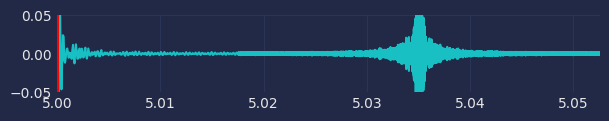

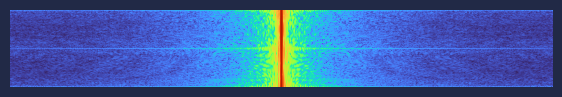

In [7]:
time = gtime([[1e-1, 50], [1e-7, 580], [7e-5, 250], [7e-6, 5000]])
plt.figure(figsize=(7,1))
plt.plot(time, efm[:, 0])
plt.plot([5 + 1e-7 * 580, 5 + 1e-7 * 580], [-0.5, 0.5], 'r')
plt.xlim(4.99999, time[-1])
plt.ylim(-0.05, 0.05)
plt.show()

plt.figure(figsize=(7,1))
plt.imshow((efm[-5000:, :].T.abs() + 1e-4).log(), aspect='auto', cmap=plt.cm.turbo)
plt.axis(False)
plt.show()

In [8]:
se_data = efm[-5000:, :].T
time = torch.linspace(0., 7e-6 * 5000, 5000)
se_data.shape, time.shape

(torch.Size([256, 5000]), torch.Size([5000]))

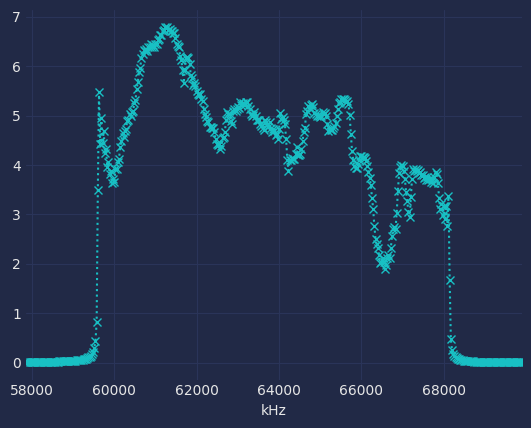

torch.Size([256, 421])


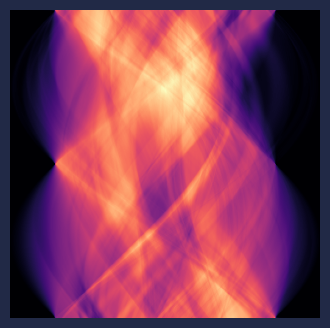

In [9]:
spin_densities = torch.fft.fftn(se_data, dim=-1)
freq = torch.fft.fftfreq(se_data.shape[1], d=(time[-1] - time[0]) / time.shape[0])

freq = freq[:freq.shape[0]//2]
spin_densities = spin_densities[:, :spin_densities.shape[1]//2].abs()
spin_densities.shape

fl, fh = (1500 - B1.max().item()) * gyromagnetic_ratio, (1500 + B1.max().item()) * gyromagnetic_ratio
plt.plot(freq, spin_densities[0], 'x:')
plt.xlim(fl, fh)
plt.xlabel('kHz')
plt.show()

sd = spin_densities[:, (freq - fl).abs().argmin():(freq - fh).abs().argmin()]
print(sd.shape)
plt.figure(figsize=(4,4))
plt.imshow(sd, aspect='auto', cmap=plt.cm.magma)
plt.axis(False)
plt.show()

In [10]:
se_data.shape, time.shape

(torch.Size([256, 5000]), torch.Size([5000]))

In [11]:
time = torch.linspace(-7e-6 * 2500, 7e-6 * 2500, 5000)
# time = torch.linspace(0, 7e-6 * 5000, 5000)
se = se_data * (2j * math.pi * 1500 * gyromagnetic_ratio * time).exp()
baseband = torch.fft.ifftshift(torch.fft.fft(se, dim=-1), dim=-1)
baseband = baseband[:, baseband.shape[-1]//2 - 210:baseband.shape[-1]//2 + 210]
ks = torch.fft.ifft(torch.fft.ifftshift(baseband, dim=-1), dim=-1)
sd = torch.fft.ifftshift(torch.fft.fft(ks, dim=-1), dim=-1)
ks.shape, sd.shape

(torch.Size([256, 420]), torch.Size([256, 420]))

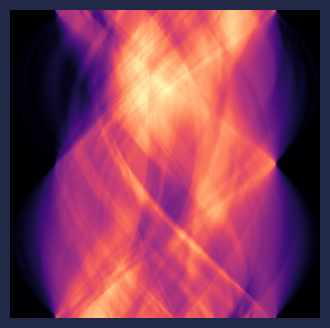

In [12]:
plt.figure(figsize=(4,4))
plt.imshow(sd.abs(), aspect='auto', cmap=plt.cm.magma)
plt.axis(False)
plt.show()

In [13]:
theta = torch.linspace(0, 180, steps=256).deg2rad()[:, None, None].cuda()
t = torch.linspace(-7e-6 * 2500, 7e-6 * 2500, 420).cuda()
x = torch.linspace(-1.0, 1.0, 256).cuda() # x [m]
y = torch.linspace(-1.0, 1.0, 256).cuda() # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
B1 = X[None, :, :] * torch.sin(theta) + Y[None, :, :] * torch.cos(theta)
B1 *= 100

In [33]:
m_est = torch.zeros_like(B1[0]).view(-1, 1).cfloat().cuda()

for i in tqdm(range(5)):
    for j in range(B1.shape[0]):
        E = (-2j * math.pi * gyromagnetic_ratio * B1[j] * t[:, None, None, None]).exp().transpose(0,1)
        E = E.flatten(2).flatten(0,1)
        update = (((ks[j].view(-1, 1).cuda() - E @ m_est.cfloat()) / E.norm(p=2, dim=0, keepdim=True)).T * E.T.conj()).mean(-1).view(-1, 1)
        m_est = m_est + 9e-3 * update

100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


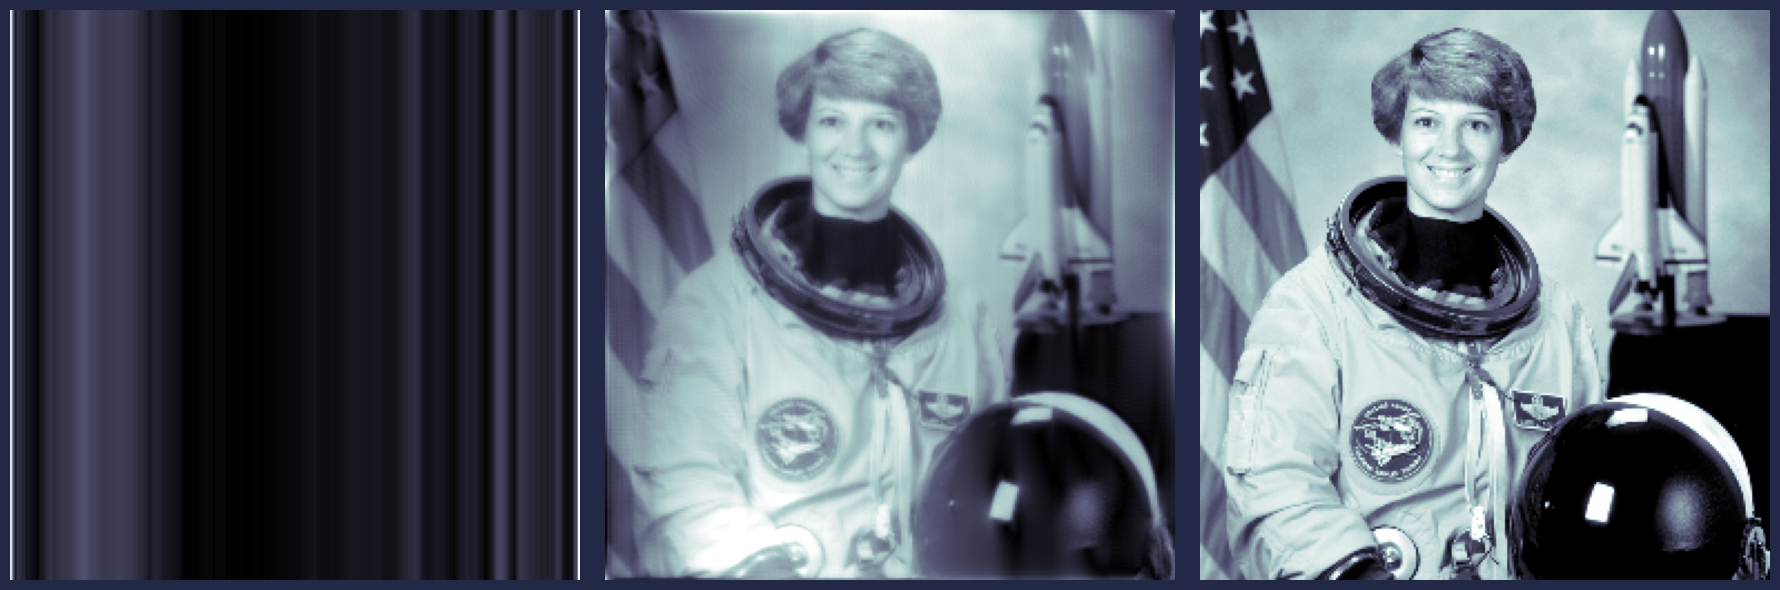

In [34]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(update.cpu().reshape_as(B1[0]).abs(), cmap=plt.cm.bone)
ax[0].axis(False)
ax[1].imshow(m_est.cpu().reshape_as(B1[0]).abs(), cmap=plt.cm.bone, vmax=m_est.abs().quantile(0.99))
ax[1].axis(False)
ax[2].imshow(rho_map, cmap=plt.cm.bone)
ax[2].axis(False)
plt.tight_layout()
plt.show()

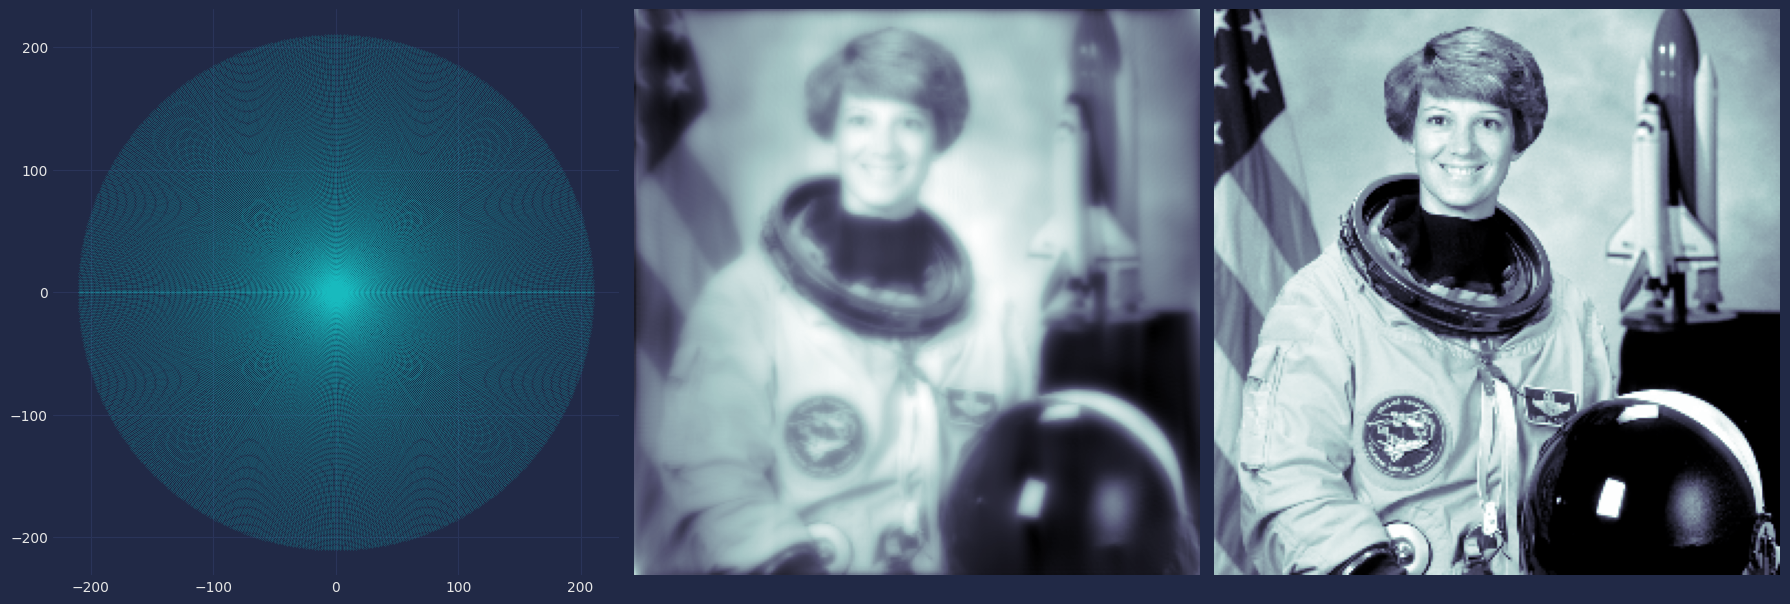

In [60]:
get_rot_mat = lambda t: torch.stack([torch.cos(t), -torch.sin(t), torch.sin(t), torch.cos(t)]).reshape(2,2)

kx = torch.linspace(-420/2, 420/2, steps=420)
ktraj = torch.stack([
    kx,
    torch.zeros_like(kx),
])
# angles = torch.arange(256)
angles = torch.linspace(0, 180, steps=256)
grid = torch.cat([get_rot_mat(angle.deg2rad()) @ ktraj for angle in angles], dim=1)

rimg = nufft.nufft_adjoint(ks.cuda(), grid.T.cuda(), out_shape=(1, 360, 360), oversamp=5., width=2).cpu().abs()[0].T
rimg = rimg[rimg.shape[0]//2-128:rimg.shape[0]//2+128, rimg.shape[1]//2-128:rimg.shape[1]//2+128]

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(grid[0], grid[1], s=0.01)
ax[0].set_aspect('equal')
ax[1].imshow(rimg, cmap=plt.cm.bone)
ax[1].axis(False)
ax[2].imshow(img[:, :, 0], cmap=plt.cm.bone)
ax[2].axis(False)
plt.tight_layout()
plt.show()

$N: 180 \times 256 \times 256$

$K: 5000$

$s(t) = \sum_{i=0}^N M_{xi}(t) = \sum_{i=0}^N \rho_i \cdot e^{2 \pi j \omega_i t + \phi_i} = \sum_{i=0}^N \rho_i \cdot e^{2 \pi j \gamma (B_0 + G_i) t + \phi_i}$

$s(t) = \sum_{k=0}^K A_k e^{2 \pi j \omega_k t + \phi_i}$